In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [9]:
def load_images_from_folder(folder):
    """Load images from a directory and convert to grayscale if not already."""
    images = []
    filenames = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Ensure images are read in grayscale
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [10]:
def extract_lbp_features(images, P=8, R=1):
    lbp_images = []
    for image in images:
        lbp = local_binary_pattern(image, P, R, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, P * R + 3),
                                 range=(0, P * R + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_images.append(hist)
    return lbp_images

In [11]:
def perform_clustering_with_elbow_method(edge_features, cluster_range):
    wcss = []
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=None)
        kmeans.fit(edge_features)
        wcss.append(kmeans.inertia_)  

    # elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, wcss, 'bo-', markerfacecolor='red', markersize=10)
    plt.title('Elbow Method to Determine Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Within-cluster sum of squares)')
    plt.grid(True)
    plt.show()

  

In [12]:
def perform_clustering(features, n_clusters, n_init=10):
    best_score = -1
    best_labels = None

    # Multiple times clustering to find the best clustering outcome
    for _ in range(n_init):
        kmeans = KMeans(n_clusters=n_clusters, random_state=None)
        labels = kmeans.fit_predict(features)
        if len(set(labels)) > 1:  
            score = silhouette_score(features, labels)
            if score > best_score:
                best_score = score
                best_labels = labels

    print(f"Testing {n_clusters} clusters: Best Silhouette Score = {best_score}")
    return best_labels

In [13]:
def display_clustered_images(images, labels, filenames):
    n_clusters = len(set(labels))
    fig, axs = plt.subplots(n_clusters, figsize=(15, n_clusters*3))
    for i in range(n_clusters):
        cluster_images = [images[j] for j in range(len(images)) if labels[j] == i]
        if cluster_images:
            combined_image = np.hstack(cluster_images)
            axs[i].imshow(combined_image.astype('uint8'))
            axs[i].set_title(f'Cluster {i+1}')
            axs[i].axis('off')
    plt.show()

    for i in range(n_clusters):
        print(f"Cluster {i+1}: {[filename for j, filename in enumerate(filenames) if labels[j] == i]}")

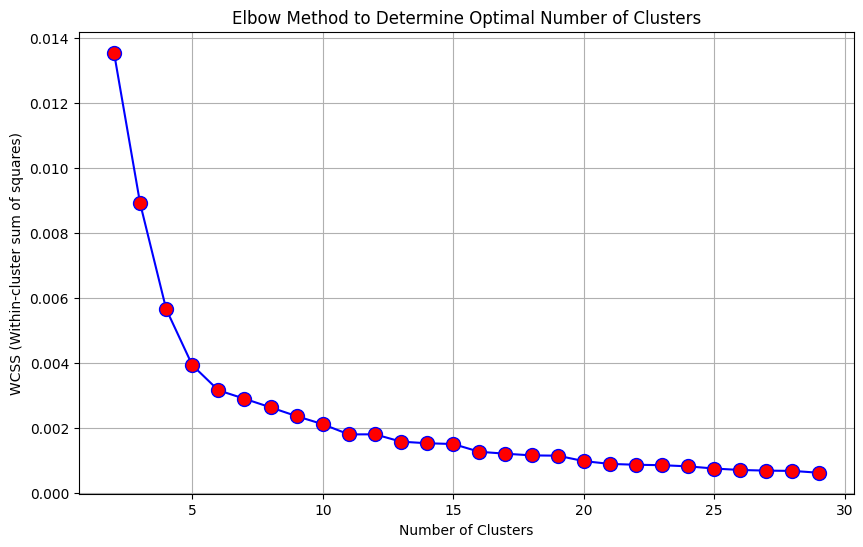

Testing 22 clusters: Best Silhouette Score = 0.44105677906794066


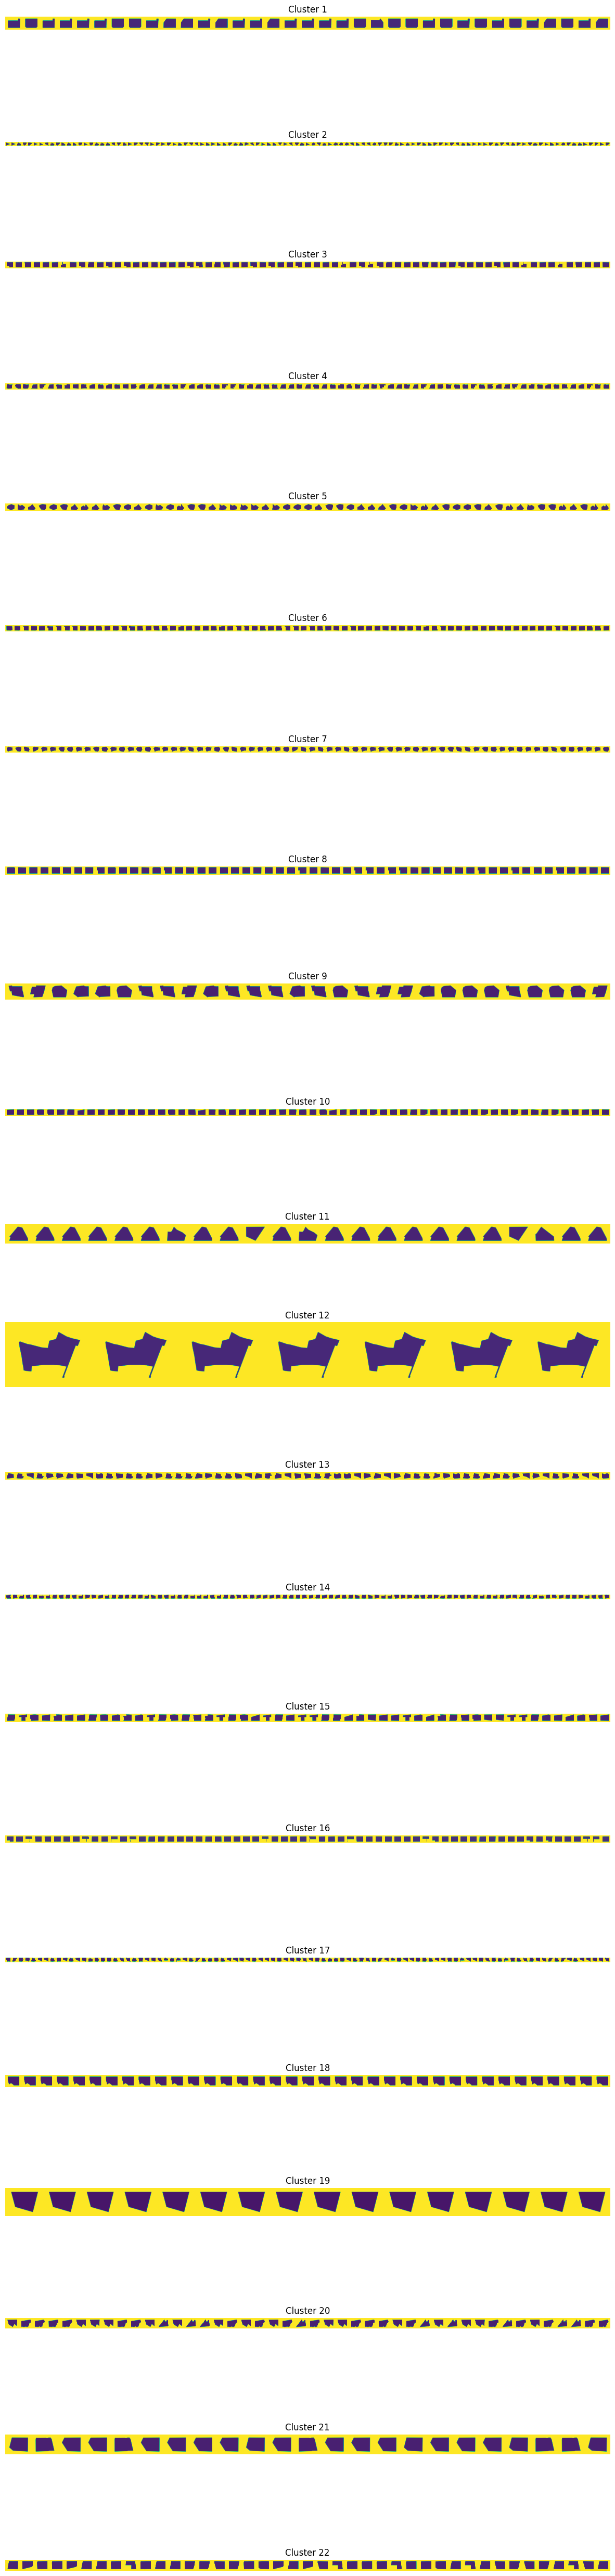

Cluster 1: ['0020.jpg', '0074.jpg', '0136.jpg', '0157.jpg', '0167.jpg', '0199.jpg', '0231.jpg', '0259.jpg', '0294.jpg', '0310.jpg', '0316.jpg', '0346.jpg', '0357.jpg', '0369.jpg', '0374.jpg', '0414.jpg', '0421.jpg', '0427.jpg', '0491.jpg', '0514.jpg', '0537.jpg', '0551.jpg', '0565.jpg', '0573.jpg', '0747.jpg', '0749.jpg', '0761.jpg', '0765.jpg', '0894.jpg', '0930.jpg', '0982.jpg', '1079.jpg', '1103.jpg', '1139.jpg', '1153.jpg']
Cluster 2: ['0022.jpg', '0027.jpg', '0036.jpg', '0042.jpg', '0088.jpg', '0091.jpg', '0092.jpg', '0099.jpg', '0110.jpg', '0112.jpg', '0122.jpg', '0139.jpg', '0161.jpg', '0165.jpg', '0169.jpg', '0173.jpg', '0179.jpg', '0184.jpg', '0189.jpg', '0214.jpg', '0239.jpg', '0251.jpg', '0258.jpg', '0291.jpg', '0318.jpg', '0319.jpg', '0323.jpg', '0331.jpg', '0339.jpg', '0341.jpg', '0343.jpg', '0383.jpg', '0384.jpg', '0388.jpg', '0390.jpg', '0409.jpg', '0428.jpg', '0432.jpg', '0433.jpg', '0441.jpg', '0468.jpg', '0477.jpg', '0479.jpg', '0500.jpg', '0501.jpg', '0503.jpg', '050

In [14]:
image_directory = 'E7-images'
image_size = (224, 224)  # Size expected by MobileNetV2

# Load and preprocess images
images, filenames = load_images_from_folder(image_directory)

# Extract features using a CNN
features = extract_lbp_features(images)

# Cluster images based on extracted features
cluster_range = range(2, 30)  # Range of cluster sizes to test
perform_clustering_with_elbow_method(features, cluster_range)
best_labels = perform_clustering(features,n_clusters=22)

# Display best clustering results

display_clustered_images(images, best_labels, filenames)